# Image t-SNE

This notebook will take you through the process of generating a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) of a set of images, using a feature vector for each image derived from the activations of the last fully-connected layer in a pre-trained convolutional neural network (convnet).

To go through this, you must first have gone through the notebook which generates feature vectors for a folder of images (`8a_image_search.ipnyb`). 
 
If you'd like to follow the last section which converts the t-SNE points to a grid assignment, you'll need [bmcfee's fork of Mario Klingemann's RasterFairy](https://github.com/bmcfee/RasterFairy), which can be installed with `pip` in with the following command.

    pip install -U git+https://github.com/bmcfee/RasterFairy/ --user

Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [152]:
%matplotlib inline
import os
import random
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE

First, we will load our image paths and feature vectors from the previous notebook (`image-search.ipynb`) into memory. We can print their contents to get an idea of what they look like. If you did not run this previous notebook, you need to go through that first to generate the saved feature vectors file `features_caltech101.p`.

In [153]:
images, pca_features, pca = pickle.load(open('image_analysis.p', 'rb'))

labeled_images = pd.read_csv("tsne_data_labeled.csv")
u = labeled_images.category.unique()

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

n_col = []

for img, f in list(zip(images, pca_features)):
    l_img = labeled_images[labeled_images["image"] == img].values[0]
    v_func = np.vectorize(lambda c: (0, 10)[c == l_img[3]])
    val = v_func(u)
    n_col.append(val)
    
n_col_2 = np.concatenate((pca_features, np.array(n_col)), axis=1, out=None)
print(n_col_2)

image: nyc_rats/shutterstock_83469022.jpg, features: 27.01,6.13,7.64,-12.53... 
image: nyc_rats/download (5).jpeg, features: 70.01,38.82,-18.93,0.01... 
image: nyc_rats/images (30).jpeg, features: 33.14,9.53,-14.33,0.65... 
image: nyc_rats/images (2).jpeg, features: -8.16,-17.80,-9.41,12.08... 
image: nyc_rats/2467024537_01bc902b97_k.jpg, features: -28.92,12.61,12.97,-17.33... 
[[ 27.00920868   6.12988234   7.64173841 ...   0.           0.
    0.        ]
 [ 70.00585938  38.81721115 -18.93448448 ...   0.           0.
    0.        ]
 [ 33.13798523   9.53416061 -14.33067417 ...   0.           0.
    0.        ]
 ...
 [ 34.85140991   8.39387512  16.48201561 ...   0.           0.
    0.        ]
 [ -7.96068478 -13.85345078   0.59703499 ...   0.           0.
    0.        ]
 [ 12.14004421   7.26093435   1.08322752 ...   0.           0.
    0.        ]]


In our dataset that we've loaded, there are 9144 images. Although in principle, t-SNE works with any number of images, it's difficult to place that many tiles in a single image. So instead, we will take a random subset of 1000 images and plot those on a t-SNE instead. This step is optional, or you can try changing `num_images_to_plot`.

In [154]:
# num_images_to_plot = 159

# if len(images) > num_images_to_plot:
#     sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
#     images = [images[i] for i in sort_order]
#     pca_features = [pca_features[i] for i in sort_order]

It is usually a good idea to first run the vectors through a faster dimensionality reduction technique like [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to project your data into an intermediate lower-dimensional space before using t-SNE. This improves accuracy, and cuts down on runtime since PCA is more efficient than t-SNE. Since we have already projected our data down with PCA in the previous notebook, we can proceed straight to running the t-SNE on the feature vectors. Run the command in the following cell, taking note of the arguments:

- `n_components` is the number of dimensions to project down to. In principle it can be anything, but in practice t-SNE is almost always used to project to 2 or 3 dimensions for visualization purposes.
- `learning_rate` is the step size for iterations. You usually won't need to adjust this much, but your results may vary slightly. 
- `perplexity` refers to the number of independent clusters or zones t-SNE will attempt to fit points around. Again, it is relatively robust to large changes, and usually 20-50 works best. 
- `angle` controls the speed vs accuracy tradeoff. Lower angle means better accuracy but slower, although in practice, there is usually little improvement below a certain threshold.

In [168]:
X = np.array(n_col_2)
tsne = TSNE(n_components=2, learning_rate=100, perplexity=40, angle=0.1, verbose=2, n_iter=3000).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 156 samples in 0.000s...
[t-SNE] Computed neighbors for 156 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 156 / 156
[t-SNE] Mean sigma: 28.077326
[t-SNE] Computed conditional probabilities in 0.011s
[t-SNE] Iteration 50: error = 64.4594269, gradient norm = 0.6747378 (50 iterations in 0.042s)
[t-SNE] Iteration 100: error = 61.6831436, gradient norm = 0.7363541 (50 iterations in 0.025s)
[t-SNE] Iteration 150: error = 71.3661346, gradient norm = 0.5848886 (50 iterations in 0.024s)
[t-SNE] Iteration 200: error = 70.2343674, gradient norm = 0.5237488 (50 iterations in 0.022s)
[t-SNE] Iteration 250: error = 66.3658066, gradient norm = 0.5962473 (50 iterations in 0.021s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.365807
[t-SNE] Iteration 300: error = 0.8858947, gradient norm = 0.0065243 (50 iterations in 0.021s)
[t-SNE] Iteration 350: error = 0.6921344, gradient norm = 0.0020594

Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable `tsne` contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [169]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

Finally, we will compose a new RGB image where the set of images have been drawn according to the t-SNE results. Adjust `width` and `height` to set the size in pixels of the full image, and set `max_dim` to the pixel size (on the largest size) to scale images to.

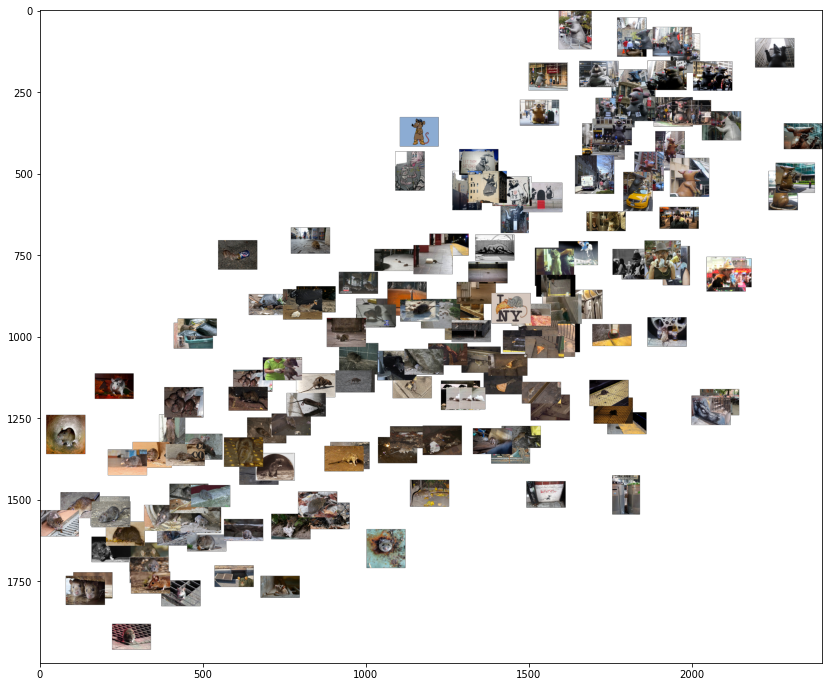

In [157]:
width = 2400
height = 2000
max_dim = 120

img_array = []

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
    img_array.append((img, x, y))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

You can save the image to disk:

In [158]:
with open("tsne_data.csv", "w", newline='') as file:
    for (img, x, y) in img_array:
        line = img + "," + str(x) + "," + str(y)
        file.write(line)
        file.write('\n')

In [159]:
full_image.save("example-tSNE-caltech101.png")

Now that we have generated our t-SNE, one more nice thing we can optionally do is to take the 2d embedding and assign it to a grid, using [RasterFairy](https://github.com/Quasimondo/RasterFairy). We can optionally choose a grid size of rows (`nx`) and columns (`ny`), which should be equal to the number of images you have. If it is less, then you can simply cut the `tsne` and `images` lists to be equal to `nx * ny`.

If you omit the `target=(nx, ny)` argument, RasterFairy will automatically choose an optimal grid size to be as square-shaped as possible. RasterFairy also has options for embedding them in a grid with irregular borders as well (see the GitHub page for more details).

You can also save the t-SNE points and their associated image paths for further processing in another environment.

In [160]:
tsne_path = "example-tSNE-points-caltech101.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to example-tSNE-points-caltech101.json


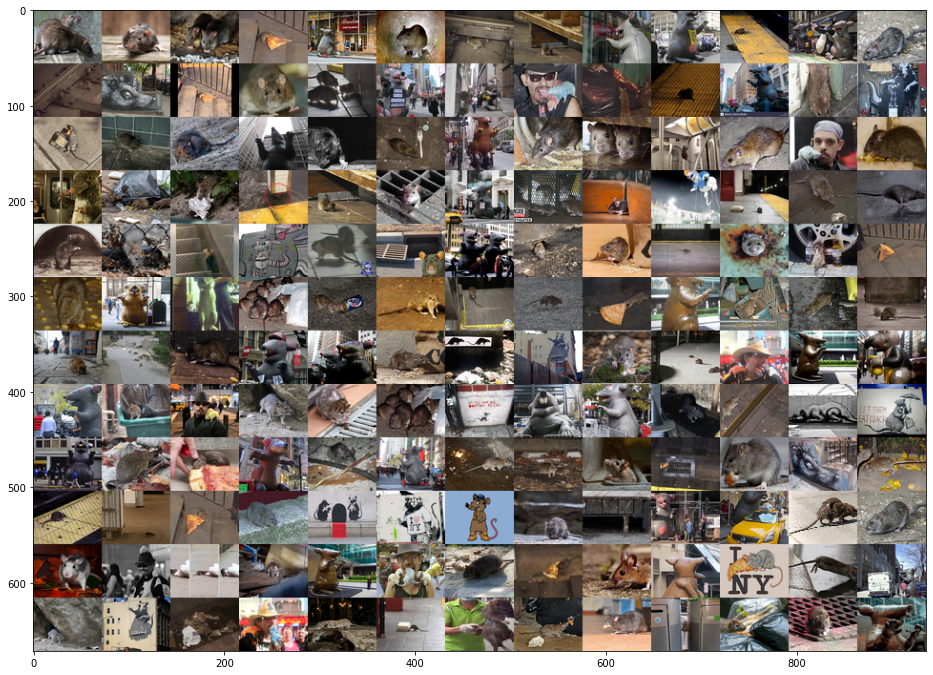

In [164]:
label_data = pd.read_csv("tsne_data.csv", header=None)

x = label_data[1].values
y = label_data[2].values

images = label_data[0]
tsne2 = np.array(list(zip(x,y)))

target_wid = 6000
target_height = 4800

# nx * ny = 1000, the number of images
nx = 13
ny = 12

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne2, target=(nx, ny))


tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

Now finally, we can make a new image of our grid. Set the `tile_width` and `tile_height` variables according to how big you want the individual tile images to be. The resolution of the output image is `tile_width * nx` x `tile_height * ny`. The script will automatically center-crop all the tiles to match the aspect ratio of `tile_width / tile_height`.

In [170]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 13
ny = 12

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

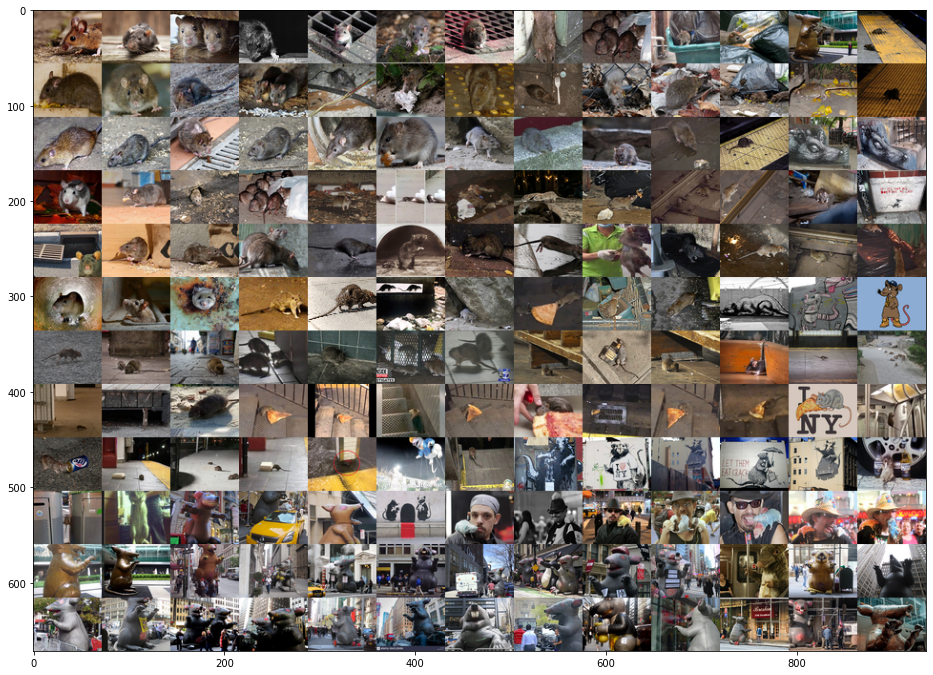

In [171]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

Finally, we can save the gridded t-SNE to disk as well.

In [59]:
grid_image.save("example-tSNE-grid-caltech101.jpg")